### Common Functions

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from tensorflow.keras.datasets import mnist
from matplotlib.patches import Ellipse

# creates XY_table out of img and only takes koordinates where the pixle value is bigger than 0
# the table consists of [x, y] where x is the column in the img array and y is the row in the img array (when seen in data viewer)
def create_XY_table(img):
    result = []
    for i in range(28):
        for j in range(28):
            if(img[i][j] > 0):
                result.append([j, i])
    return np.array(result)

# creates a table of coorinates for all pixels in the image. 
# This is needed to give that as input in the score function of the GMM after its trained
def create_XY_table_from_training_data(img):
    result = []
    shape = img.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            result.append([j, i])
    return np.array(result)

# It creates an XY_table for all the imgs in the input array. Then it returns a Big table with all the Koordinates of all the arrays
def create_XY_table_for_imgs(imgs):
    if len(imgs) == 0:
        return np.array([])
    
    result = create_XY_table(imgs[0])
    for img in imgs[1:]:
        XY_table = create_XY_table(img)
        result = np.concatenate((result, XY_table), axis=0)
    return np.array(result)

def plot_gmm(gmm, ax, color='red'):
    for i in range(gmm.n_components):
        mean = gmm.means_[i]
        cov = gmm.covariances_[i]

        v, w = np.linalg.eigh(cov)
        v = 2. * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])

        angle = np.degrees(np.arctan2(u[1], u[0]))
        ell = Ellipse(xy=mean, width=v[0], height=v[1], angle=angle, edgecolor=color, facecolor='none', lw=2)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.6)
        ax.add_patch(ell)

def sub_plot_gmm_probabilities_in_subplot(fig, ax, score_data, fitted_gmms, ensemble_type="simple_avg"):
    XY_grid, X_grid, Y_grid = generate_mesh_grid(score_data)
    log_likelihoods_grid = np.array([gmm.score_samples(XY_grid) for gmm in fitted_gmms])
    ensembled_log_likelihoods = ensemble_log_likelihoods(ensemble_type, log_likelihoods_grid)
    averaged_probabilities_grid = np.exp(ensembled_log_likelihoods).reshape(X_grid.shape)

    prob_min = np.min(averaged_probabilities_grid)
    prob_max = np.max(averaged_probabilities_grid)
    normalized_probabilities_grid = (averaged_probabilities_grid - prob_min) / (prob_max - prob_min)

    contour = ax.contourf(X_grid, Y_grid, normalized_probabilities_grid, levels=20, cmap='viridis')
    fig.colorbar(contour)
    ax.invert_yaxis()
    return XY_grid

def generate_mesh_grid(train_data):
    x = np.linspace(train_data[:, 0].min() - 1, train_data[:, 0].max() + 1, 100)
    y = np.linspace(train_data[:, 1].max() + 1, train_data[:, 1].min() - 1, 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    XY_grid = np.array([X_grid.ravel(), Y_grid.ravel()]).T
    return XY_grid, X_grid, Y_grid

# overlays all the digits in the input array over another and averages all the points in the digit 2D array
def overlay_mnistdigits(digit_imgs):
    result = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            total_pixle_value = 0
            for digit in digit_imgs:
                total_pixle_value = total_pixle_value + digit[i][j]
            result[i][j] = round(total_pixle_value/len(digit_imgs))
    return result

def convert_pixel_to_probabilities(digit_img):
    result = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            result[i][j] = digit_img[i][j]/255
    return result

def create_img_from_fitted_gmm(fitted_gmms, score_data_table):
    predictions = calculate_predictions_of_gmms(fitted_gmms, score_data_table)
    result = np.zeros((28, 28))
    for indices, prediction in zip(score_data_table, predictions):
        result[indices[1]][indices[0]] = round(prediction*255)
    return result


### IMPORTANT XY_table must be from img
def compare_error_of_GMM_and_IMG(fitted_gmms, train_data_table, img, ensemble_type="simple_avg"):
    img_with_probs = convert_pixel_to_probabilities(img)
    predictions = calculate_predictions_of_gmms(fitted_gmms, train_data_table, ensemble_type)

    error_map = np.zeros_like(img_with_probs)
    if len(train_data_table) != len(predictions):
        raise ValueError(f"xy_table has to have the same length as the predictions array")
    
    for coord, prediction in zip(train_data_table, predictions):
        error_per_pixel = (img_with_probs[coord[1]][coord[0]] - prediction)**2
        if(error_per_pixel > 1 or error_per_pixel < 0 and len(fitted_gmms) == 1):
            print(f'error per pixel is out of range!! "{error_per_pixel}", gmm_components: "{fitted_gmms[0].n_components}"')
        error_map[coord[1]][coord[0]] = error_per_pixel
    total_error = np.sum(error_map)

    return total_error, error_map

def calculate_predictions_of_gmms(fitted_gmms, score_data, ensemble_type="simple_avg"):
    log_likelihoods = np.array([gmm.score_samples(score_data) for gmm in fitted_gmms])
    ensembled_loglikelihoods = ensemble_log_likelihoods(ensemble_type, log_likelihoods)

    densities = np.exp(ensembled_loglikelihoods)

    densities_min = np.min(densities)
    densities_max = np.max(densities)
    predictions = (densities - densities_min) / (densities_max - densities_min)
    return predictions

def ensemble_log_likelihoods(ensemble_type: str, log_likelihoods):
    match ensemble_type:
        case "simple_avg":
            return np.mean(log_likelihoods, axis=0)
        case "median":
            return np.median(log_likelihoods, axis=0)
        case _:
            raise ValueError("Unknown ensemble type. Has to be out of [simple_avg, median]")
        
def compare_error_of_IMG_and_IMG(img1, img2):
    img1_probs = convert_pixel_to_probabilities(img1)
    img2_probs = convert_pixel_to_probabilities(img2)

    total_error = 0
    for i in range(28):
        for j in range(28):
            total_error += (img1_probs[i][j] - img2_probs[i][j])**2
    return total_error

### EXPERIMENTS ###
def experiment_1(single_digit_img, overlayed_digits, gmm_components):
    error_between_img_and_img = compare_error_of_IMG_and_IMG(overlayed_digits, single_digit_img)

    XY_table = create_XY_table(single_digit_img)
    train_data_table = create_XY_table_from_training_data(single_digit_img)
    gmm_01 = GaussianMixture(n_components=gmm_components, covariance_type='full')
    gmm_01.fit(XY_table)

    error_between_img_and_gmm, error_map = compare_error_of_GMM_and_IMG([gmm_01], train_data_table, overlayed_digits)
    return [error_between_img_and_img, error_between_img_and_gmm]

def experiment_single_vs_ensemble(score_data_table, digit_img, number_of_gmms_ensemble):
    XY_table_2 = create_XY_table(digit_img)

    gmm = GaussianMixture(n_components=12, covariance_type='full')
    gmm.fit(XY_table_2)

    gmm_component_numbers = np.random.randint(7, 20, number_of_gmms_ensemble)
    gmm_array = [GaussianMixture(n_components=12, covariance_type='full') for _, component_number in zip(range(number_of_gmms_ensemble), gmm_component_numbers)]

    for one_gmm in gmm_array:
        one_gmm.fit(XY_table_2)

    err_img_gmm, error_map_1 = compare_error_of_GMM_and_IMG([gmm], score_data_table, digit_img)
    err_img_gmm_2, error_map_2 = compare_error_of_GMM_and_IMG(gmm_array, score_data_table, digit_img)
    return [err_img_gmm, err_img_gmm_2]

### Common Variables

In [16]:
# Step 1: Load and preprocess MNIST data
(X_train, Y_train), (_, _) = mnist.load_data()  # X_train are the images of numbers represented in 2D arrays and Y_train is an array of numbers representing the lables of on the images

digit = 8
X_digit = X_train[Y_train == digit]
X_digit_img = X_digit[36]

overlayed_digits = overlay_mnistdigits(X_digit[:400])
score_data_table = create_XY_table_from_training_data(X_digit_img)
gmm_01 = GaussianMixture(n_components=16, covariance_type='full', reg_covar=1e-5)

test_img  = X_digit[29]
XY_table = create_XY_table(test_img)
gmm_01.fit(XY_table)
print(gmm_01.n_iter_)


7


### Check Error Calculation

error between overlayed img and gmm trained on single img is: "19.96617279731273"


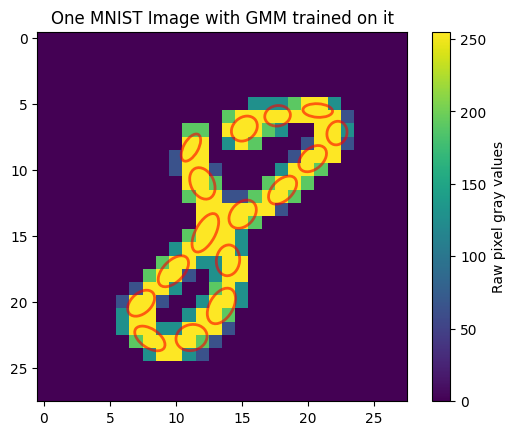

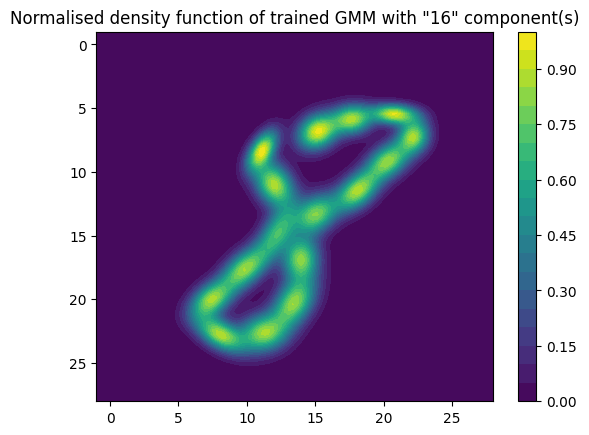

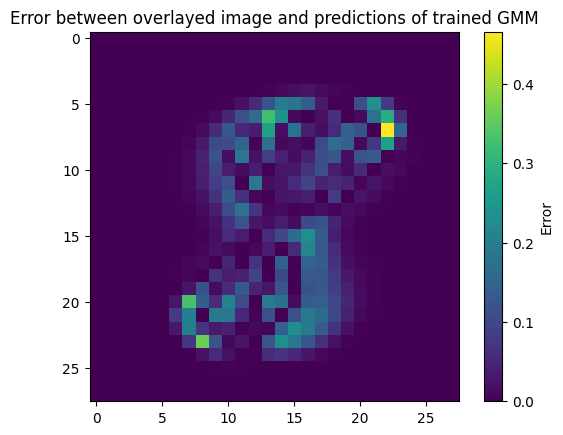

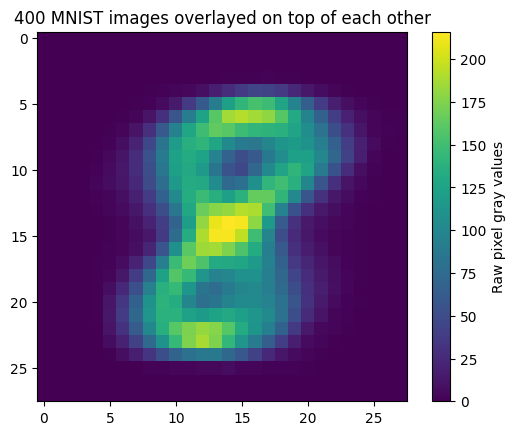

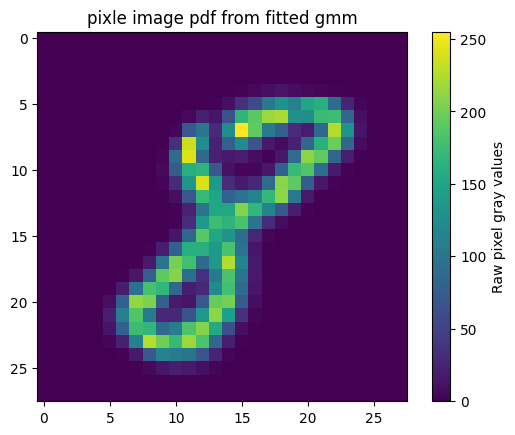

In [17]:
error_between_img_and_img = compare_error_of_IMG_and_IMG(overlayed_digits, test_img)

pixel_img_of_gmm_pdf = create_img_from_fitted_gmm([gmm_01], score_data_table)

error_between_img_and_gmm, error_map = compare_error_of_GMM_and_IMG([gmm_01], score_data_table, overlayed_digits)
print(f'error between overlayed img and gmm trained on single img is: "{error_between_img_and_gmm}"')

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()

plot_gmm(gmm_01, ax)

sub_plot_gmm_probabilities_in_subplot(fig2, ax2, score_data_table, [gmm_01])
ax2.set_title(f'Normalised density function of trained GMM with "{gmm_01.n_components}" component(s)')

pixel_val = ax.imshow(test_img)
ax.set_title("One MNIST Image with GMM trained on it")
cbar = fig.colorbar(pixel_val, ax=ax, orientation='vertical')
cbar.set_label("Raw pixel gray values")

im_error = ax3.imshow(error_map)
ax3.set_title("Error between overlayed image and predictions of trained GMM")
cbar = fig3.colorbar(im_error, ax=ax3, orientation='vertical')
cbar.set_label("Error")

pixel_val_2 = ax4.imshow(overlayed_digits)
ax4.set_title("400 MNIST images overlayed on top of each other")
cbar_2 = fig4.colorbar(pixel_val_2, ax=ax4, orientation='vertical')
cbar_2.set_label("Raw pixel gray values")

pixel_val_3 = ax5.imshow(pixel_img_of_gmm_pdf)
ax5.set_title('pixle image pdf from fitted gmm')
cbar_3 = fig5.colorbar(pixel_val_3, ax=ax5, orientation='vertical' )
cbar_3.set_label("Raw pixel gray values")

plt.show()

### Experiment 2

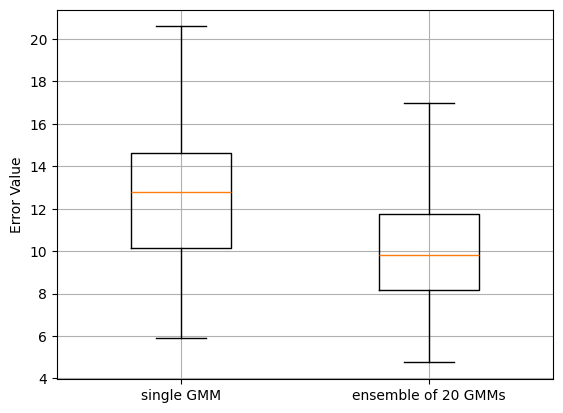

In [7]:
result = []
for img in X_digit[30:80]:
    result.append(experiment_single_vs_ensemble(score_data_table, img, 20))
result = np.array(result)

#digit_img_2 = X_digit[26]
#print("EXPERIMENT 2")
#print(f'The error between the img and one GMM is "{err_img_gmm}"')
#print(f'The error between the img and ensemble of GMMs is "{err_img_gmm_2}"')
#print()
#fig, ax = plt.subplots()
#fig2, ax2 = plt.subplots()
#fig3, ax3 = plt.subplots()
#plot_gmm(gmm2, ax)
#ax.imshow(digit_img_2, cmap='gray')
#ax.set_title(f'EXPERIMENT 2: One GMM on MNIST Digit "{digit}"')
#ax2.set_title(f'EXPERIMENT 2: Probabilities of Ensemble GMM trained on MNIST Digit "{digit}')
#sub_plot_gmm_probabilities_in_subplot(fig2, ax2, train_data_table, gmm_array)
#sub_plot_gmm_probabilities_in_subplot(fig3, ax3, train_data_table, [gmm2])

data = [result[:, 0], result[:, 1]]
positions = [1,2]
plt.boxplot(data, positions=positions, widths=0.4, showfliers=False)
plt.ylabel('Error Value')
plt.grid(True)
plt.xticks(positions, ['single GMM', 'ensemble of 20 GMMs'])
#plt.title("Errors between MNIST image and single GMM or ensemble of GMMs")
plt.show()

## Boxplot of performance of GMMs depending on components
- Here 50 GMMs for each number of components is trained on 50 images out of the overlayed images
- Then it is compared which component number works best for the gmms and produces the lowest error
- the chosen component numbers are [9, 12, 20, 30, 40]

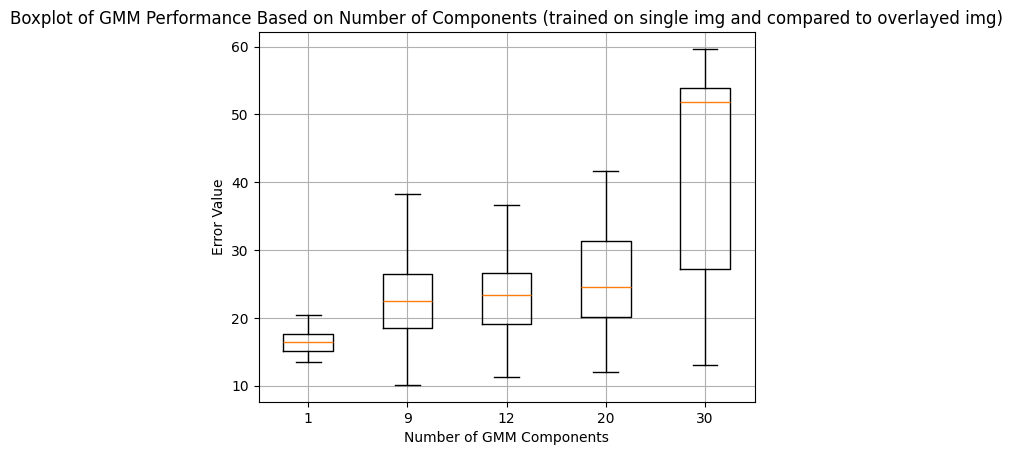

In [5]:
def experiment_1_2(single_digit_img, overlayed_digits, gmm_components):
    XY_table = create_XY_table(single_digit_img)
    gmm_01 = GaussianMixture(n_components=gmm_components, covariance_type='full')
    gmm_01.fit(XY_table)

    error_between_img_and_gmm, error_map = compare_error_of_GMM_and_IMG([gmm_01], score_data_table, overlayed_digits)
    return error_between_img_and_gmm

gmm_comp_numbers = np.array([1, 9, 12, 20, 30])

result = []

for component_number in gmm_comp_numbers:
    zwischen_result = []
    for img in X_digit[20:70]:
        zwischen_result.append(experiment_1_2(img, overlayed_digits, component_number))
    result.append(np.array(zwischen_result))

plt.boxplot(result, tick_labels=gmm_comp_numbers, showfliers=False)
plt.title('Boxplot of GMM Performance Based on Number of Components (trained on single img and compared to overlayed img)')
plt.xlabel('Number of GMM Components')
plt.ylabel('Error Value')
plt.grid(True)
plt.show()

### Boxplotting what comes closer to overlayed image
- 50 experiments are done where its compared if one image out of the overlayed images performs better or a GMM trained on that image

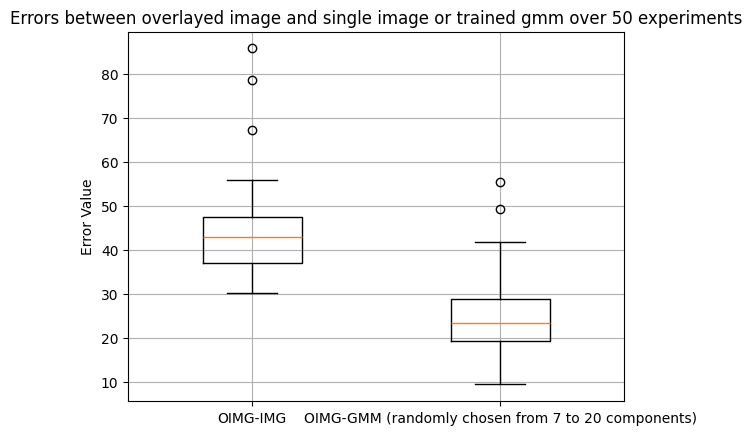

In [120]:
result_1 = []
gmm_component_numbers = np.random.randint(7, 20, 50)
for img, component_number in zip(X_digit[20:70], gmm_component_numbers):
    result_1.append(experiment_1(img, overlayed_digits, component_number))
result_1 = np.array(result_1)

positions = [1,2]
data = [result_1[:, 0], result_1[:, 1]]
plt.boxplot(data, positions=positions, widths=0.4)
plt.ylabel('Error Value')
plt.grid(True)

plt.xticks(positions, ['OIMG-IMG', 'OIMG-GMM (randomly chosen from 7 to 20 components)'])
plt.title("Errors between overlayed image and single image or trained gmm over 50 experiments")
plt.show()

### Boxplotting which component Number comes closer to the image

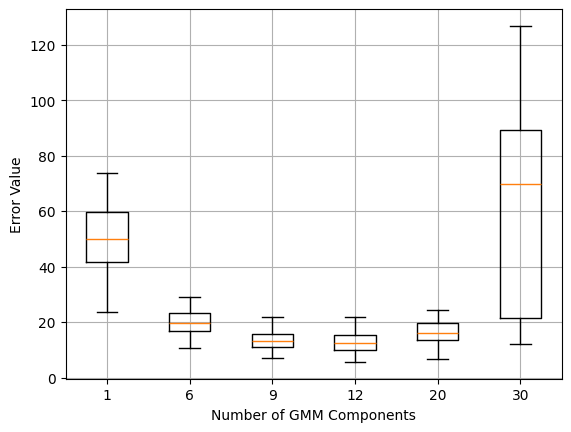

In [41]:
def experiment_3(single_digit_img, gmm_component_number):
    XY_table = create_XY_table(single_digit_img)
    train_data_table = create_XY_table_from_training_data(single_digit_img)
    gmm = GaussianMixture(n_components=gmm_component_number, covariance_type='full')
    gmm.fit(XY_table)
    error_between_img_and_gmm, error_map = compare_error_of_GMM_and_IMG([gmm], train_data_table, single_digit_img)
    return error_between_img_and_gmm

gmm_comp_numbers = np.array([1, 6, 9, 12, 20, 30, 40])

result = []

for component_number in gmm_comp_numbers:
    zwischen_result = []
    for img in X_digit[20:70]:
        zwischen_result.append(experiment_3(img, component_number))
    result.append(np.array(zwischen_result))

plt.boxplot(result, tick_labels=gmm_comp_numbers, showfliers=False)
#plt.title('Boxplot of GMM Performance Based on Number of Components (trained on single img and compared to that image)')
plt.xlabel('Number of GMM Components')
plt.ylabel('Error Value')
plt.grid(True)
plt.show()


### Ensemble Member number

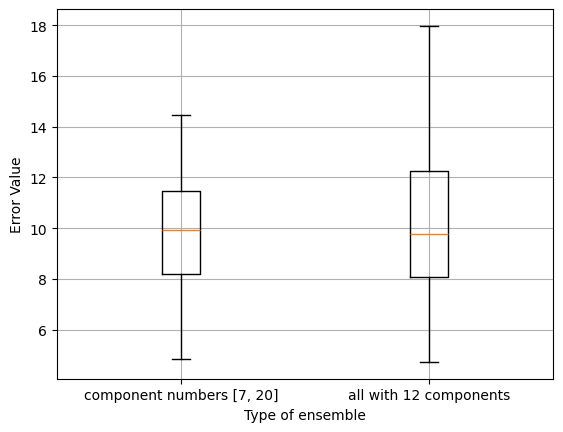

In [11]:
def experiment_ensemble_members(score_data, digit_img, ensemble_number):
    train_table = create_XY_table(digit_img)
    gmm_component_numbers = np.random.randint(7, 20, ensemble_number)
    gmm_array = [GaussianMixture(n_components=component_number, covariance_type='full') for _, component_number in zip(range(ensemble_number), gmm_component_numbers)]
    gmm_array_2 = [GaussianMixture(n_components=12) for _ in range(ensemble_number)]

    for one_gmm in gmm_array:
        one_gmm.fit(train_table)

    for one_gmm in gmm_array_2:
        one_gmm.fit(train_table)
    
    [error_gmm_diff_pars, error_map] = compare_error_of_GMM_and_IMG(gmm_array, score_data, digit_img)
    [error_gmm_same_pars, error_map] = compare_error_of_GMM_and_IMG(gmm_array_2, score_data, digit_img)

    return [error_gmm_diff_pars, error_gmm_same_pars]

#gmm_ensemble_numbers = [5, 10, 20, 30, 40, 50]

result = []
for img in X_digit[30:80]:
    result.append(experiment_ensemble_members(score_data_table, img, 20))
result = np.array(result)
data = [result[:, 0], result[:, 1]]

plt.boxplot(data, tick_labels=['component numbers [7, 20]', 'all with 12 components' ], showfliers=False)
#plt.title('Boxplot of GMM Performance Based on Number of Components (trained on single img and compared to that image)')
plt.xlabel('Type of ensemble')
plt.ylabel('Error Value')
plt.grid(True)
plt.show()

### Comparison between simple averaging and chosing median

Error for the simple avg ensemble is: "55.90129951628569"
Error for the median ensemble is: "15.402312960784819"


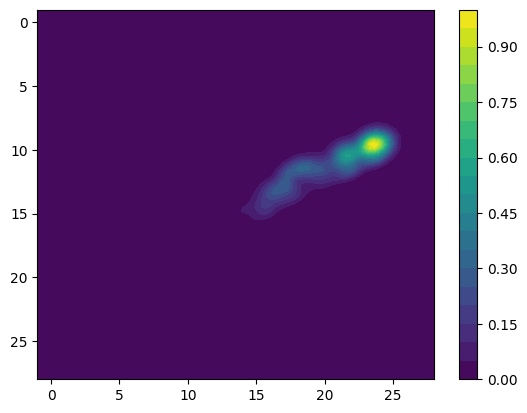

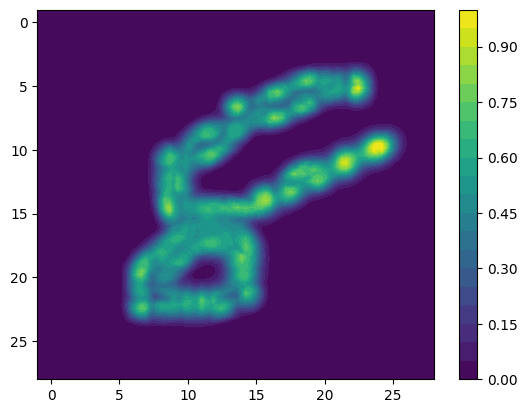

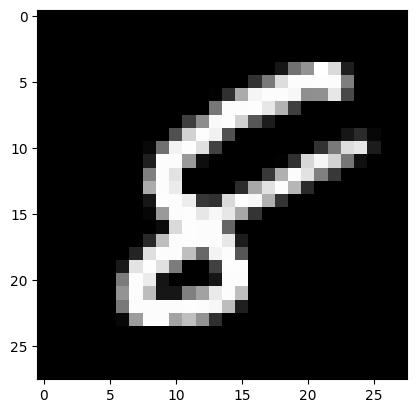

In [40]:
def experiment_combination(digit_img, component_number):
    train_table = create_XY_table(digit_img)
    gmm_array = [GaussianMixture(n_components=component_number) for _ in range(20)]
    gmm_array_2 = [GaussianMixture(n_components=component_number) for _ in range(20)]

    for one_gmm in gmm_array:
        one_gmm.fit(train_table)

    for one_gmm in gmm_array_2:
        one_gmm.fit(train_table)

    [error_gmm_simple_avg, error_map] = compare_error_of_GMM_and_IMG(gmm_array, score_data_table, digit_img, ensemble_type="simple_avg")
    [error_gmm_median, error_map] = compare_error_of_GMM_and_IMG(gmm_array_2, score_data_table, digit_img, ensemble_type="median")

    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()

    sub_plot_gmm_probabilities_in_subplot(fig1, ax1, score_data_table, gmm_array, "simple_avg")
    sub_plot_gmm_probabilities_in_subplot(fig2, ax2, score_data_table, gmm_array_2, "median")

    return [error_gmm_simple_avg, error_gmm_median]

img = X_digit[37]
(error_simpl_avg, error_median) = experiment_combination(img, 30)

fig1, ax1 = plt.subplots()

ax1.imshow(img, cmap='gray')

print(f'Error for the simple avg ensemble is: "{error_simpl_avg}"')
print(f'Error for the median ensemble is: "{error_median}"')



plt.show()